# Comparación entre STEAD y dataset del ICGC
En este análisis se pretende encontrar las principales diferencias entre los sismos recopilados del ICGC para este trabajo y el dataset STEAD proporcionado por la universidad de Standford para entrenar IAs y justificar el uso del primero. Las principales diferencias entre los dos datasets son las siguientes:

* Distribución de magnitudes
* Tipo de estación y magnitud
* Frecuencias de muestreo
* Picks manuales y autopicks

A continuación las analizaremos en profundidad usando las siguientes librerías:



In [1]:
#Librerías
##Estándard
import math
import numpy as np

##Descargadas
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

## Distribución de magnitudes
Como podemos ver en el EDA realizado por Kaelynn Rose la distribución de magnitudes, profundidades y distancia a las estaciones sísmicas es la siguiente:

<img src="./STEAD_earthquake_distribution.png" alt="STEAD earthquake distribution">

Los terremotos analizados tienen una magnitud media de 1.52, lo cual es bastante alto para la media de Catalunya, como veremos a continuación, además Kaetlynn selecciona 60.000 de ellos de forma aleatoria, con los cual es aún menos probable encontrar terremotos de poca magnitud en su dataset de entrenamiento. A continuación veremos como se distribuyen los terremotos registrados en Catalunya, pondremos el foco en los últimos años, ya que ha habido un salto tecnológico desde los años 2000 y ahora se cuenta con mejores métodos de detección, por lo que se pueden encontrar terremotos más pequeños. A continuación vamos a obtener las mismas distribuciones a partir de nuestros datos:

Terremotos registrados: 15814
Magnitud media: 0.35
Profundidad media: 4.11
Registros de terremotos: 110702
Distancia a estaciones media: 89.47


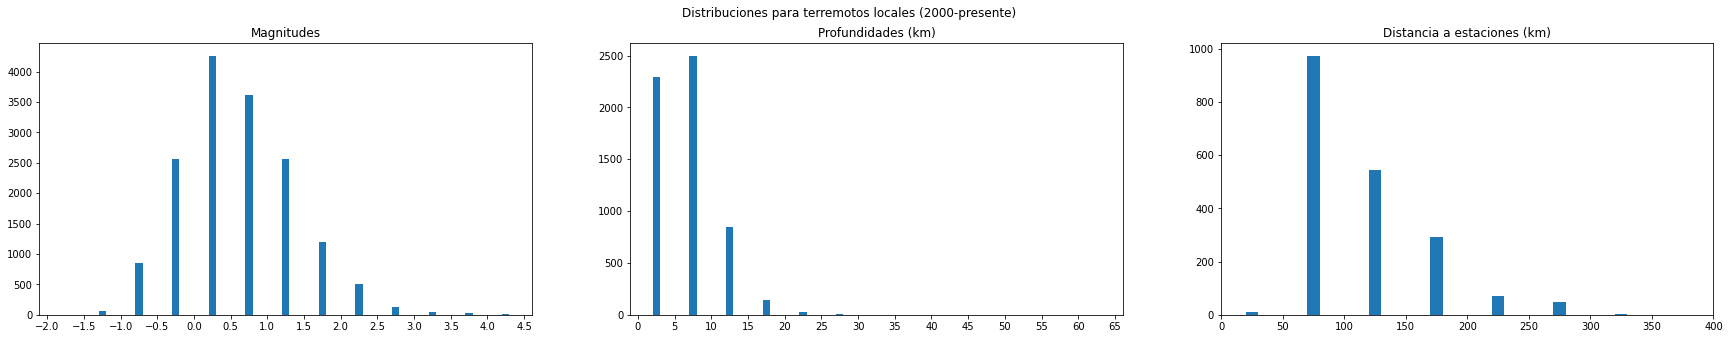

In [2]:
#Connectamos con la base de datos
connection = sqlite3.connect("../seismic_cat.db")
cursor = connection.cursor()


#Creamos un dataset con los terremotos
earthquake_query = """
select code,depth,magnitude from earthquake
"""
earthquakes = cursor.execute(earthquake_query).fetchall()
earthquake_df = pd.DataFrame(earthquakes)
earthquake_df.columns = ('code', 'depth', 'magnitude')

#Creamos un dataset con los registros
register_query = """
    select code,name,dist from register
"""
registers = cursor.execute(register_query)
register_df = pd.DataFrame(registers)
register_df.columns = ('code', 'station', 'dist')

#Transformamos la distancias de las estaciones a km para poder comparar
transform_to_km = lambda angle: np.radians(angle)*6371
register_df['dist'] = transform_to_km(register_df['dist'])


#Cerramos la conexión con la base de datos
cursor.close()
connection.close()


#Definimos una función para generar una distribución
def classify_col(my_dataframe, my_col, my_step):
    ##Generamos unos margenes usando las magnitudes máxima y mínima del dataset
    magnitude_max = math.ceil(max(my_dataframe[my_col]))
    magnitude_min = math.floor(min(my_dataframe[my_col]))
    magnitude_range = np.arange(magnitude_min, magnitude_max, my_step)

    ##Contamos las magnitudes que caen en cada rango
    magnitude_counts = []
    for magnitude in magnitude_range:
        m_b = magnitude
        m_t = magnitude + 0.5
        magnitude_counts.append(
            len(my_dataframe[(my_dataframe[my_col]>=m_b) & (my_dataframe[my_col]<m_t)])
        )
    
    ##Generamos el histograma
    plt.hist(
        magnitude_range,
        bins= magnitude_range,
        weights=magnitude_counts,
        rwidth=0.2,
        align='mid'
        )
    plt.xticks(magnitude_range)

    ##Devolvemos el número de terremotos y el valor de magnitud de la moda
    return (len(my_dataframe), np.average(magnitude_range, weights=magnitude_counts))


#Ejecución
plt.figure(figsize=(30,5))
plt.suptitle('Distribuciones para terremotos locales (2000-presente)')
plt.subplot(131)
plt.title('Magnitudes')
total_e, av_magnitude = classify_col(earthquake_df, 'magnitude', 0.5)
print('Terremotos registrados: {}'.format(total_e))
print('Magnitud media: {}'.format(round(av_magnitude,2)))

plt.subplot(132)
plt.title('Profundidades (km)')
total_e, av_depth = classify_col(earthquake_df, 'depth', 5)
print('Profundidad media: {}'.format(round(av_depth,2)))

plt.subplot(133)
plt.title('Distancia a estaciones (km)')
total_r, av_depth = classify_col(register_df, 'dist', 50)
print('Registros de terremotos: {}'.format(total_r))
print('Distancia a estaciones media: {}'.format(round(av_depth,2)))

Podemos ver que la mayoría de terremotos registrados tienen una magnitud entre 0 y 0.5, lo que nos da a entender que la necesidad de tener un dataset de entrenamiento que muestre muchos terremotos pequeños, con una señal más camuflada en el ruido de la propia estación sísmica. A continuación vemos que esta tendencia a registrar magnitudes bajas se acentúa conforme pasan los años:

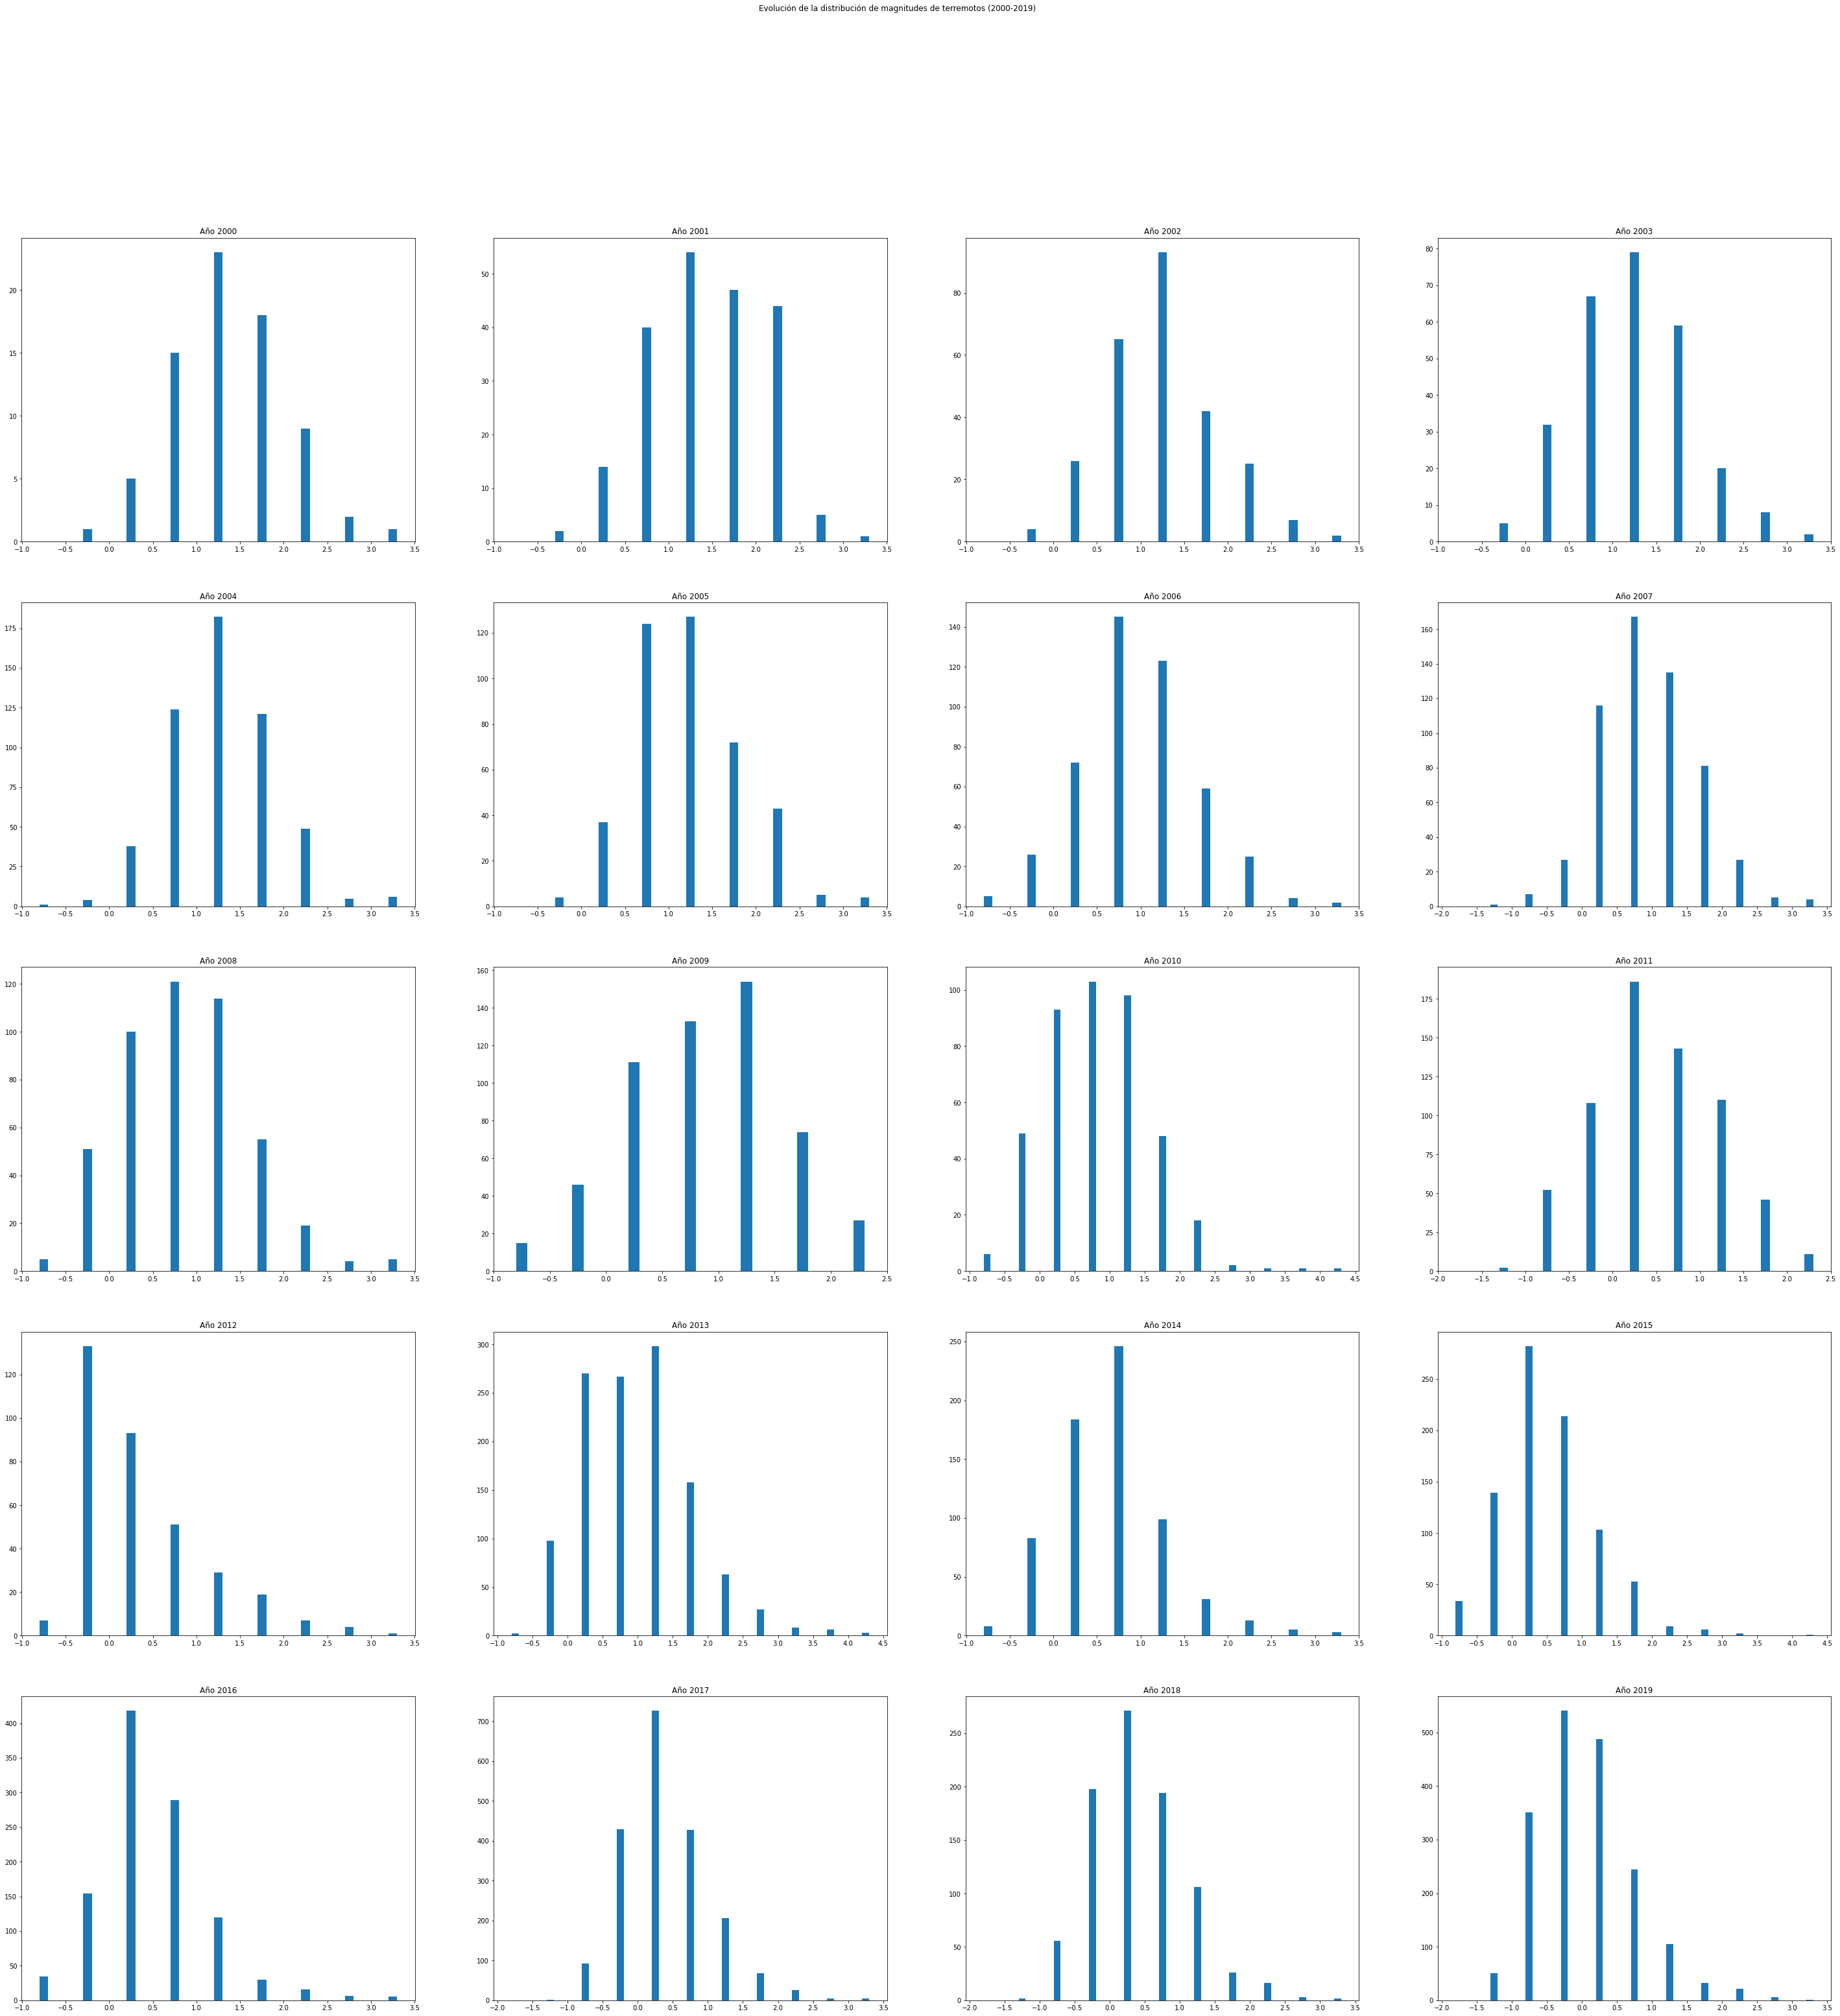

In [3]:
#Seleccionamos el rango de años y conectamos a la base de datos
years = range(2000,2020,1)
connection = sqlite3.connect("../seismic_cat.db")
cursor = connection.cursor()

#Creamos una función para buscar los terremotos que produjeron cada año
def get_year_earthquakes(my_year):
    ##Consultamos la base de datos
    my_query = """
        select code,magnitude from earthquake where date>="{}-01-01" and date<"{}-01-01"
    """.format(my_year, my_year + 1)
    year_earthquakes = cursor.execute(my_query).fetchall()

    ##Creamos y devolvemos el dataframe
    earthquake_df = pd.DataFrame(year_earthquakes)
    earthquake_df.columns = ('code', 'magnitude')
    return earthquake_df

#Devolvemos la distribución de cada año usando un bucle for y subplots
plt.figure(figsize=(50,50))
plt.suptitle('Evolución de la distribución de magnitudes de terremotos (2000-2019)')
totals = []
avs = []
for i,year in enumerate(years):
    earthquake_df = get_year_earthquakes(year)
    plt.subplot(5,4,i+1)
    plt.title('Año {}'.format(year))
    total, av = classify_col(earthquake_df, 'magnitude', 0.5)
    totals.append(total)
    avs.append(av)
    
cursor.close()
connection.close()

([<matplotlib.axis.XTick at 0x1ad17d5f700>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

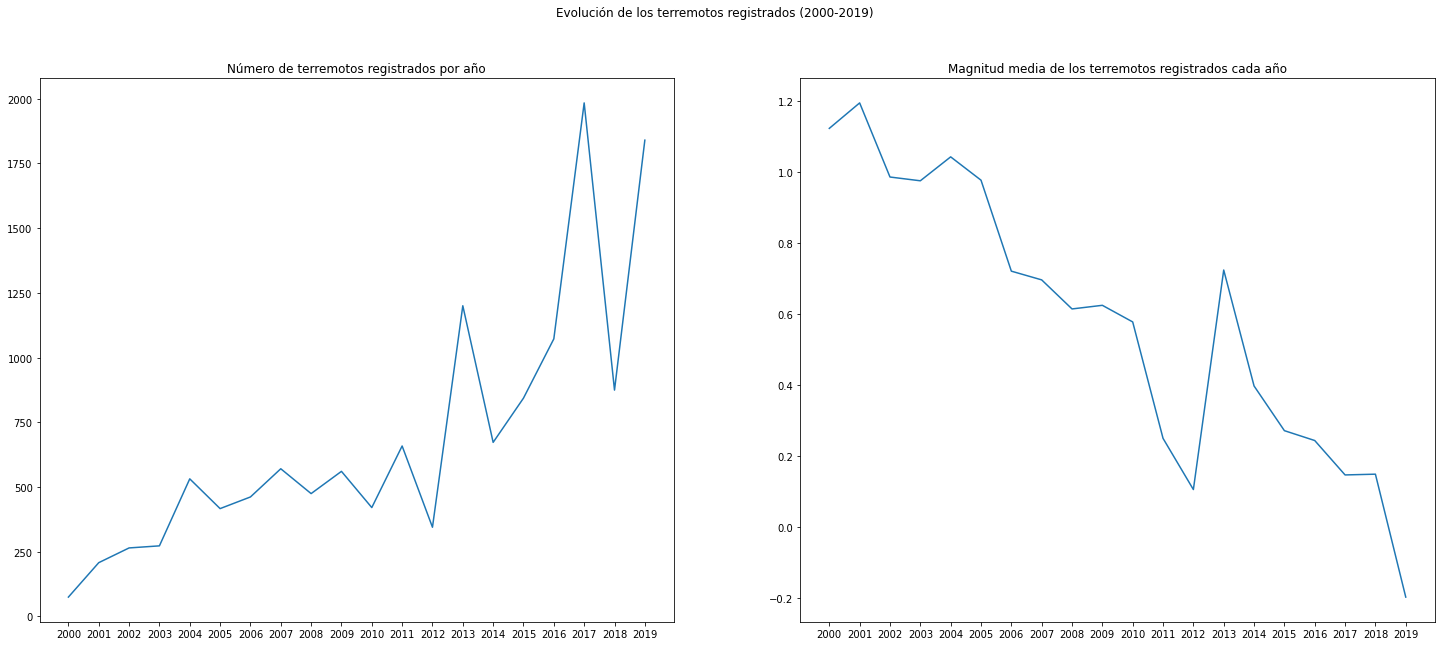

In [4]:
#Terremotos totales y magnitudes medias de cada año
plt.figure(figsize=(25,10))
plt.suptitle('Evolución de los terremotos registrados (2000-2019)')

#Terremotos totales
plt.subplot(1,2,1)
plt.title('Número de terremotos registrados por año')
plt.plot(years, totals)
plt.xticks(years)

#Magnitudes medias
plt.subplot(1,2,2)
plt.title('Magnitud media de los terremotos registrados cada año')
plt.plot(years, avs)
plt.xticks(years)

Podemos observar que con el paso de los años el número de terremotos registrados aumenta y la magnitud media disminuye, esto se traduce en un creciente registro de
terremotos de magnitudes pequeñas, por tanto cada vez es más necesario un algoritmo de clasificación que ayude a detectar y analizar terremotos de magnitudes pequeñas, que se camuflan más en el ruido de los instrumentos de las estaciones sísmicas.

Podemos observar un pico de magnitud media en 2012 que sería contrario a la tendencia general, pero este es artificial, no se debe a terremotos naturales sinó causados por humanos ya que corresponde con los terremotos causados por las perforaciones de la plataforma castor: 

https://es.wikipedia.org/wiki/Proyecto_Castor


## Tipo de estación y magnitud
Las magnitudes de los terremotos no son datos indispensables ya que siempre se pueden calcular con las amplitudes máximas de las trazas de los terremotos. Sin embargo suponen un mecanismo muy útil para clasificarlos por tanto es mejor ser coherentes y usar siempre el mismo tipo de magnitudes. **Una de las desventajas del STEAD es no se han calculado las magnitudes con el mismo criterio** debido a la variedad de instituciones de las que se han sacado los datos, de forma que han quedado distribuidas de la siguiente manera:

<img src="./Distribution-of-magnitude-scales-for-earthquake-data-ml-is-the-local-magnitude-mb-body.ppm.png" alt="STEAD magnitude distribution">

La magnitud no presenta grandes cambios entre sus diferentes métodos de cálculo, pero puede ser un problema si pretendemos crear métodos de ML para calcular la magnitud (no es nuestro caso). **El dataset del ICGC tiene la ventaja de que todas la magnitudes se han calculado con la Escala de Richter y por tanto son magnitudes locales (ml)**.

Sin embargo, y aunque la escala de Richter sea usada en los medios de comunicación y por muchos sismólogos como referencia, desde principios del siglo XXI se llego al consenso de que no era una escala universal ya que Richter la ideó haciendo un símil con la magnitud usada para medir el brillo de las estrellas en astronomía e introdujo en su fórmula parámetros de cálculo que solo deberían ser válidos para la falla de San Andrés en California. Esta dependencia con el origen del terremoto hace que la escala de Richter no sea del todo exacta en otros lugares del mundo.

Aun así, aunque no use la mejor escala para medir la magnitud, el dataset recopilado del ICGC sigue siendo mejor por su coherencia.


## Frecuencia de muestreo de las ondas P
Al mirar el análisis de Kaetlyn Rose de STEAD os encontramos con este gráfico:

<img src="./pwaves_s_waves_EDA.png" alt="P and S phases distributions">

Corresponde a las frecuencias de la posición relativa de las fases P y S dentro de las trazas del STEAD (todas son fragmentos de un minuto de duración). Mientras que la distribución de ondas S parece casi continua en las ondas P los supuestos tiempos de llegada de las fases se concentran en intervalos de 1 segundo. Esto se debe, como nos indica Kaetlyn a que las fases P se han picado en intervalos de un segundo, mientras que las fases S se han picado con una precisión de centésimas de segundo.

La poca precisión con la que se han picado las fases P puede conducir a erroes a la hora de localizar el terremoto en la traza. 

En el dataset del  ICGC ambas fases se han picado con precisiones de centésimas de segundo, de hecho en los terremotos más modernos la precisión aumenta a las milésimas de segundo, sin embargo se la muestras han sido "resampleadas" a 100Hz para que sea coherente con el resto del dataset.

## Picks manuales y autopicks
Localizar las fases P o S se conoce entre los sismólogos como picar un terremoto (pick). Otra característica del STEAD que puede ser una desventaja es que parte de sus terremotos se han picado de forma automática, mientras que en el ICGC todos los registros de fases que publican estan picados por sismólogos.
En la siguiente imágen se puede ver el porcentaje de terremotos picados de forma manual y automática dentro del STEAD:

<img src="./Proportions-of-the-status-of-P-arrival-and-S-arrival-picks-Manual-picks-are-arrival.ppm.png" alt="STEAD manual pick and autopick">